In [1]:
# Segmenting and Clustering of Barcelona Neighborhoods

In [2]:
# Webscrapping of the inner Barcelona province data from a stats URL and saving the information to a dataframe

import re
import requests
import urllib
from urllib.parse import urlsplit, urljoin, urlencode
from bs4 import BeautifulSoup
import pandas as pd
from urllib.request import urlopen
import time

url_population = "https://www.bcn.cat/estadistica/angles/dades/barris/tpob/pad/ine/a2019/ine08.htm"

html = urllib.request.urlopen(url_population).read()
soup = BeautifulSoup(html, "html.parser")

table_contents=[]
table_contents_2=[]
total = []
range_1 = []
range_2 = []
range_3 = []
range_4 = []
index_lst = []

tables=soup.find_all("td", {"class":"WhadsRowVar3"})
i=8001
for table in tables:
    string = table.get_text()
    string = string.replace(u'\xa0', u' ')
    result = ''.join([i for i in string if not i.isdigit()])
    result = result.replace(".", "").strip()
    table_contents.append(result)
    index_lst.append(i)
    i=i+1
    
tables=soup.find_all("td", {"class":"WhadsDades"})
for table in tables:
    string = table.get_text()
    string = string.replace(u'\xa0', u' ')
    result = string.replace(".", "").strip()
    table_contents_2.append(result)

table_contents_2 = table_contents_2[15:]

total = table_contents_2[::5]
range_1 = table_contents_2[1::5]
range_2 = table_contents_2[2::5]
range_3 = table_contents_2[3::5]
range_4 = table_contents_2[4::5]

df = pd.DataFrame(list(zip(index_lst,table_contents, total, range_1, range_2, range_3, range_4)), columns = ["CP","Neighborhood", "total", "0-14", "15-24", "25-64", "65+"])
df['CP'] = df['CP'].apply(lambda x: '{0:0>5}'.format(x))
df.dropna()
df.head()

,CP,Neighborhood,total,0-14,15-24,25-64,65+
0,08001,el Raval,47353,5993,4991,30936,5433
1,08002,el Barri Gòtic,18629,1425,1876,13172,2156
2,08003,la Barceloneta,14857,1146,1322,9792,2597
3,08004,"Sant Pere, Santa Caterina i la Ribera",22590,2116,2292,15013,3169
4,08005,el Fort Pienc,32349,3706,2900,18872,6871


In [3]:
# Checking the shape of the generated dataframe

df.shape

(73, 7)

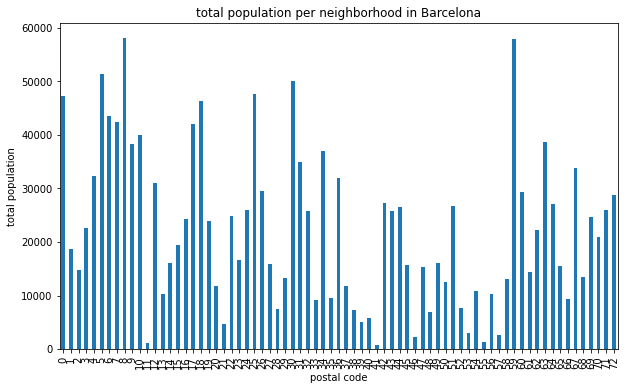

In [4]:
# Exploratory data analysis

import matplotlib.pyplot as plt

df["total"] = df["total"].astype(int)
df["total"].plot(kind='bar', figsize=(10, 6), rot=90)

plt.xlabel('postal code')
plt.ylabel('total population')
plt.title('total population per neighborhood in Barcelona')

plt.show()

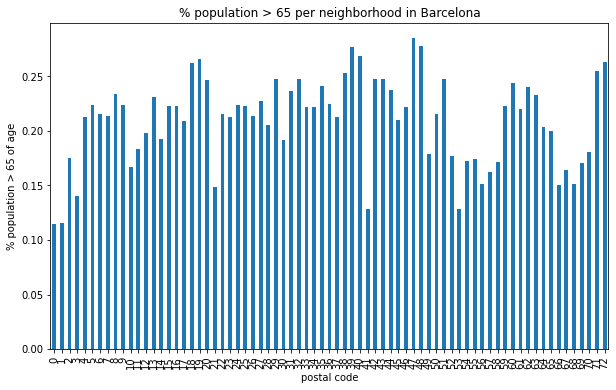

In [5]:
# Exploratory data analysis

df["65+"] = df["65+"].astype(int)
df["total"] = df["total"].astype(int)

(df["65+"] / df["total"]).plot(kind='bar', figsize=(10, 6), rot=90)

plt.xlabel('postal code')
plt.ylabel('% population > 65 of age')
plt.title('% population > 65 per neighborhood in Barcelona')

plt.show()

In [6]:
# Utilising the geocoding library to retrieve latitude and longitude data for the desired postal codes

import geocoder

lat = []
long = []

def get_latlng(postal_code):
    
    latlng_coords = None

    while(latlng_coords is None):

        g = geocoder.arcgis('{}, Barcelona, Catalunya'.format(postal_code))

        latlng_coords = g.latlng

        return latlng_coords

for CP in df["CP"]:

    lat.append(get_latlng(CP)[0])
    long.append(get_latlng(CP)[1])
    
import numpy as np

m = np.asarray(lat).astype(float).round(decimals = 3)
n = np.asarray(long).astype(float).round(decimals = 3)

df["lat"] = m
df["long"] = n

df

,CP,Neighborhood,total,0-14,15-24,25-64,65+,lat,long
0,08001,el Raval,47353,5993,4991,30936,5433,41.380,2.169
1,08002,el Barri Gòtic,18629,1425,1876,13172,2156,41.382,2.177
2,08003,la Barceloneta,14857,1146,1322,9792,2597,41.383,2.188
3,08004,"Sant Pere, Santa Caterina i la Ribera",22590,2116,2292,15013,3169,41.370,2.160
4,08005,el Fort Pienc,32349,3706,2900,18872,6871,41.396,2.201
...,...,...,...,...,...,...,...,...,...
68,08069,Diagonal Mar i el Front Marítim del Poblenou,13501,2542,1031,7882,2046,41.388,2.170
69,08070,el Besòs i el Maresme,24673,3657,2567,14237,4212,41.388,2.170
70,08071,Provençals del Poblenou,21002,3008,1831,12360,3803,41.388,2.170
71,08072,Sant Martí de Provençals,26061,3090,2231,14102,6638,41.388,2.170


In [7]:
# Cleaning those neighborhoods that are actually not in the inner Barcelona area and therefore have incorrect latitude and longitude values

df_new = df[0:42]
df_new.shape

(42, 9)

In [8]:
df_new

,CP,Neighborhood,total,0-14,15-24,25-64,65+,lat,long
0,08001,el Raval,47353,5993,4991,30936,5433,41.380,2.169
1,08002,el Barri Gòtic,18629,1425,1876,13172,2156,41.382,2.177
2,08003,la Barceloneta,14857,1146,1322,9792,2597,41.383,2.188
3,08004,"Sant Pere, Santa Caterina i la Ribera",22590,2116,2292,15013,3169,41.370,2.160
4,08005,el Fort Pienc,32349,3706,2900,18872,6871,41.396,2.201
5,08006,la Sagrada Família,51385,5292,4423,30160,11510,41.401,2.146
6,08007,la Dreta de l'Eixample,43515,5086,4002,25056,9371,41.390,2.166
7,08008,l'Antiga Esquerra de l'Eixample,42393,4558,3691,25102,9042,41.394,2.160
8,08009,la Nova Esquerra de l'Eixample,58032,6108,4885,33448,13591,41.395,2.170
9,08010,Sant Antoni,38236,3987,3110,22592,8547,41.392,2.176


In [9]:
import numpy as np
import json
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium

# Create an address instance for Barcelona

address = 'Barcelona, BCN'

geolocator = Nominatim(user_agent="tor_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Barcelona are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Barcelona are 41.3828939, 2.1774322.


In [10]:
# Create a map of Barcelona with markers using latitude and longitude values to visualise the neighborhoods

map_Barcelona = folium.Map(location=[latitude, longitude], zoom_start=12)

for lat, lng, borough, neighborhood in zip(df_new['lat'], df_new['long'], df_new['Neighborhood'], df_new['CP']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Barcelona)  
    
map_Barcelona

In [11]:
# Define a function to perform queries in FourSquare and retrieve data from venues in Barcelona

CLIENT_ID = 'L5GODISZELLEH5MDGV0KMUFKIMHUT15NIKD0SFPRFXAALXRQ'
CLIENT_SECRET = 'EXW11RQTQWI2QY0MRL0VVRQFRKNQGZKBWE2QU1QJBZLN532A'
VERSION = '20180605'
LIMIT = 100

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Barcelona_venues = getNearbyVenues(names=df_new['Neighborhood'],
                                   latitudes=df_new['lat'],
                                   longitudes=df_new['long']
                                  )

In [12]:
Barcelona_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,el Raval,41.380,2.169,La Robadora,41.379500,2.170463,Gastropub
1,el Raval,41.380,2.169,La Monroe,41.378795,2.170692,Spanish Restaurant
2,el Raval,41.380,2.169,33/45,41.381059,2.167399,Cocktail Bar
3,el Raval,41.380,2.169,Filmoteca de Catalunya,41.378540,2.171101,Movie Theater
4,el Raval,41.380,2.169,A Tu Bola,41.380096,2.169054,Tapas Restaurant
...,...,...,...,...,...,...,...
2452,la Clota,41.443,2.170,Camp Futbol Guineueta,41.441464,2.170790,Soccer Field
2453,la Clota,41.443,2.170,Parc Josep Serra I Marti,41.442707,2.168331,Hot Spring
2454,la Clota,41.443,2.170,Bar 777,41.445903,2.172653,Diner
2455,la Clota,41.443,2.170,Dia %,41.439402,2.172549,Supermarket


In [13]:
# Display all unique Venue Categories to select which ones might be suitable to reply to the business question

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(Barcelona_venues["Venue Category"].unique())

['Gastropub' 'Spanish Restaurant' 'Cocktail Bar' 'Movie Theater'
 'Tapas Restaurant' 'Theater' 'Fast Food Restaurant' 'Roof Deck'
 'Jazz Club' 'Hotel' 'Beer Bar' 'Restaurant' 'Gift Shop' 'Café'
 'Mediterranean Restaurant' 'Bar' 'Garden' 'Italian Restaurant'
 'Japanese Restaurant' 'Asian Restaurant' 'Coffee Shop' 'Market'
 'Greek Restaurant' 'Sandwich Place' 'Wine Bar' 'Bookstore'
 'Mexican Restaurant' 'Pizza Place' 'Dance Studio' 'Seafood Restaurant'
 'Falafel Restaurant' 'Donut Shop' 'Opera House' 'Record Shop'
 'Shoe Store' 'Monument / Landmark' 'Skate Park' 'Indian Restaurant' 'Pub'
 'Empanada Restaurant' 'Pie Shop' 'Art Museum' 'Plaza' 'Hotel Pool'
 'Cultural Center' 'Historic Site' 'Bakery' 'Burger Joint'
 'Ice Cream Shop' 'Pedestrian Plaza' 'Hotel Bar' 'Boarding House'
 'Art Gallery' 'Bagel Shop' 'Neighborhood' 'Hot Dog Joint' 'Bridge'
 'Dessert Shop' "Women's Store" 'Baby Store' 'Fabric Shop'
 'Vegetarian / Vegan Restaurant' 'Speakeasy' 'Pharmacy' 'Ramen Restaurant'
 'Music Venu

In [14]:
# Define a list of "interesting" venues as per the business question considering where old aged people generally stop by / frequent

interesting_venues = ["Café", "Bar", "Market", "Pharmacy", "Train Station", "Supermarket", "Convenience Store", "Flower Shop", "Cafeteria", "Metro Station"]
interesting_venues

['Café',
 'Bar',
 'Market',
 'Pharmacy',
 'Train Station',
 'Supermarket',
 'Convenience Store',
 'Flower Shop',
 'Cafeteria',
 'Metro Station']

In [15]:
# Find how many "interesting" venues per neighborhood

lst = []
lst_2 = []

Neigh = Barcelona_venues["Neighborhood"].unique()

for i in Neigh:
    count = 0
    for j in Barcelona_venues[Barcelona_venues["Neighborhood"]==i]["Venue Category"]:
        if j in interesting_venues:
            count = count +1
    lst.append(count)
    lst_2.append(i)
    
def_df = df_new

m = np.asarray(lst).astype(int)
def_df["count interesting venues"] = m

def_df.head()

<ipython-input-15-18f4200980da>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  def_df["count interesting venues"] = m


,CP,Neighborhood,total,0-14,15-24,25-64,65+,lat,long,count interesting venues
0,08001,el Raval,47353,5993,4991,30936,5433,41.380,2.169,11
1,08002,el Barri Gòtic,18629,1425,1876,13172,2156,41.382,2.177,7
2,08003,la Barceloneta,14857,1146,1322,9792,2597,41.383,2.188,13
3,08004,"Sant Pere, Santa Caterina i la Ribera",22590,2116,2292,15013,3169,41.370,2.160,3
4,08005,el Fort Pienc,32349,3706,2900,18872,6871,41.396,2.201,2


In [16]:
# Clean dataframe by getting rid of non numeric variables to be ready to perform the K-Means clustering algorithm

Clustering_df = def_df.drop(columns = ["CP", "0-14", "15-24", "25-64", "lat", "long"])
Clustering_df.head()

,Neighborhood,total,65+,count interesting venues
0,el Raval,47353,5433,11
1,el Barri Gòtic,18629,2156,7
2,la Barceloneta,14857,2597,13
3,"Sant Pere, Santa Caterina i la Ribera",22590,3169,3
4,el Fort Pienc,32349,6871,2


In [17]:
# Perform K-Means clustering algorithm on the Barcelona dataset with the desired variables: total population, population over 65 of age, and number of "interesting" venues per neighborhood

Clus_Final = Clustering_df.drop('Neighborhood', 1)

from sklearn.preprocessing import StandardScaler

# Use a standard scaler to avoid bias towards bigger value variables

Clus_dataSet_final = StandardScaler().fit_transform(Clus_Final)

# Assume 3 clusters

kclusters = 3

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Clus_dataSet_final)

# Insert predicted labels into dataframe

Clustering_df.insert(0, "Cluster Labels", kmeans.labels_)

Clustering_df.head()

,Cluster Labels,Neighborhood,total,65+,count interesting venues
0,0,el Raval,47353,5433,11
1,2,el Barri Gòtic,18629,2156,7
2,2,la Barceloneta,14857,2597,13
3,1,"Sant Pere, Santa Caterina i la Ribera",22590,3169,3
4,0,el Fort Pienc,32349,6871,2


In [18]:
# Merge the two dataframes to be able to display clustered neighborhoods in a map

Barcelona_merged = Clustering_df.merge(def_df, left_index=True, right_index=True,
                 how='outer', suffixes=('', '_y'))
Barcelona_merged.drop(Barcelona_merged.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)

Barcelona_merged.head()

,Cluster Labels,Neighborhood,total,65+,count interesting venues,CP,0-14,15-24,25-64,lat,long
0,0,el Raval,47353,5433,11,08001,5993,4991,30936,41.380,2.169
1,2,el Barri Gòtic,18629,2156,7,08002,1425,1876,13172,41.382,2.177
2,2,la Barceloneta,14857,2597,13,08003,1146,1322,9792,41.383,2.188
3,1,"Sant Pere, Santa Caterina i la Ribera",22590,3169,3,08004,2116,2292,15013,41.370,2.160
4,0,el Fort Pienc,32349,6871,2,08005,3706,2900,18872,41.396,2.201


In [19]:
# Display a map with the created neighborhood clusters

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(Barcelona_merged['lat'], Barcelona_merged['long'], Barcelona_merged['Neighborhood'], Barcelona_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color = rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [20]:
# Finally check which of the clusters is suitable to respond to the business question

Barcelona_merged

,Cluster Labels,Neighborhood,total,65+,count interesting venues,CP,0-14,15-24,25-64,lat,long
0,0,el Raval,47353,5433,11,08001,5993,4991,30936,41.380,2.169
1,2,el Barri Gòtic,18629,2156,7,08002,1425,1876,13172,41.382,2.177
2,2,la Barceloneta,14857,2597,13,08003,1146,1322,9792,41.383,2.188
3,1,"Sant Pere, Santa Caterina i la Ribera",22590,3169,3,08004,2116,2292,15013,41.370,2.160
4,0,el Fort Pienc,32349,6871,2,08005,3706,2900,18872,41.396,2.201
5,0,la Sagrada Família,51385,11510,9,08006,5292,4423,30160,41.401,2.146
6,0,la Dreta de l'Eixample,43515,9371,1,08007,5086,4002,25056,41.390,2.166
7,0,l'Antiga Esquerra de l'Eixample,42393,9042,1,08008,4558,3691,25102,41.394,2.160
8,0,la Nova Esquerra de l'Eixample,58032,13591,5,08009,6108,4885,33448,41.395,2.170
9,0,Sant Antoni,38236,8547,6,08010,3987,3110,22592,41.392,2.176


In [21]:
Barcelona_merged["total"] = Barcelona_merged["total"].astype(int)
Barcelona_merged["65+"] = Barcelona_merged["65+"].astype(int)
Barcelona_merged[["total","65+","count interesting venues"]].max()

total                       58032
65+                         13591
count interesting venues       13
dtype: int64

In [22]:
Barcelona_merged[Barcelona_merged["Cluster Labels"] == 2]

,Cluster Labels,Neighborhood,total,65+,count interesting venues,CP,0-14,15-24,25-64,lat,long
1,2,el Barri Gòtic,18629,2156,7,08002,1425,1876,13172,41.382,2.177
2,2,la Barceloneta,14857,2597,13,08003,1146,1322,9792,41.383,2.188
11,2,la Marina del Prat Vermell - Zona Franca,1196,219,8,08012,153,110,714,41.402,2.157
13,2,la Font de la Guatlla,10265,2370,7,08014,1014,877,6004,41.375,2.139
14,2,Hostafrancs,16014,3089,9,08015,1810,1302,9813,41.380,2.153
19,2,la Maternitat i Sant Ramon,23836,6345,6,08020,2880,2039,12572,41.420,2.202
21,2,"Vallvidrera, el Tibidabo i les Planes",4698,700,10,08022,839,531,2628,41.407,2.133
22,2,Sarrià,24901,5376,7,08023,4414,2754,12357,41.413,2.144
23,2,les Tres Torres,16591,3526,8,08024,2841,2090,8134,41.412,2.157
24,2,Sant Gervasi - la Bonanova,25919,5790,8,08025,4106,3006,13017,41.408,2.172
